# Financial US Stocks data reports classification 
    
   
# Marcos Barragán & Adrián González 
    
# Machine Learning
    
### Final Practice
    
### 15/01/2021
    
__CUNEF__

# Class Classification models

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split 
import pickle
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
import scikitplot as skplt
import matplotlib.pyplot as plt
import matplotlib.pyplot as pltimport 
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression # Regresión logit
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

In [2]:
data_train = pd.read_excel('../data/data_train.xlsx', index_col=0)
data_test = pd.read_excel('../data/data_test.xlsx', index_col=0)

We have to drop `Div_vs_sector` and `price_var`, because they are the other variables we are taking as target.

Furthermore, it is important to drop out `PRICE_VAR[%]` variable, because class comes out from it (transformed into dicotomic).

In [3]:
data_train = data_train.drop(['PRICE_VAR[%]',
                              'Div_vs_sector',
                              'price_var'], axis=1)

data_test = data_test.drop(['PRICE_VAR[%]',
                            'Div_vs_sector',
                            'price_var'], axis=1)

We pass Class variable as object just to apply correctly the Pipeline.

In [4]:
data_train['Class'] = data_train['Class'].astype('object')

data_test['Class'] = data_test['Class'].astype('object')

### Including Pipelines to process our data:

Pipeline will be used to scale our variables but, moreover, it will be used as well to remove NA values applying K-Nearest Neighbours techniques. We will consider euclidean method and weights based on their distance to the 20 nearest neighbours.

In [5]:
numeric_transformer = Pipeline(steps=[
    
                                      ('imputer', 
                                       KNNImputer(n_neighbors=20,
                                                  weights='distance', 
                                                  metric='nan_euclidean', 
                                                  copy=True)),
    
                                      ('scaler', StandardScaler())
    
                                ])

In [6]:
numeric_features = data_train.select_dtypes(include=['int64', 'float64','int32']).columns #we include all those numeric types.

In [7]:
preprocessor1 = ColumnTransformer(
                                  transformers=[
                                      ('num', numeric_transformer, numeric_features)
                                  ])

In [9]:
pl2 = '../pipelines/pipeline_class.sav'

pickle.dump(preprocessor1, open(pl2, 'wb'))

### Train and test definition:

We need to reconsider y train and test as numeric feature once the Pipeline has been applied.

In [10]:
xtrain = data_train.drop('Class', axis=1)

ytrain = data_train['Class']
ytrain = ytrain.astype('int64')

In [11]:
xtest = data_test.drop('Class', axis=1)

ytest = data_test['Class']
ytest = ytest.astype('int64')

## Gaussian Naive-Bayes Models:

Gaussian NB is codified in Python as GaussianNB(). 

First of all, we need to load our pipeline and apply it to data:

In [13]:
pl2 = '../pipelines/pipeline_class.sav'
tratamiento = pickle.load(open(pl2, 'rb'))

In [14]:
gnb = Pipeline(steps=[
    
                      ('preprocesado', tratamiento),
    
                      ('clasificador', GaussianNB())
                     
                     ])

gnb.fit(xtrain, ytrain).predict(xtest)

array([1, 1, 1, ..., 1, 0, 1])

+ ### GNB Scores:

In [15]:
gnb.score(xtrain, ytrain)

0.5641580942068218

In [16]:
gnb.score(xtest, ytest)

0.6206642066420665

+ ### GNB Predictions and Probabilities:

In [17]:
y_pred = gnb.predict(xtest)

In [18]:
y_prob = gnb.predict_proba(xtest)

+ ### ROC GNB model:

In [19]:
def roc(model, title):
    
    skplt.metrics.plot_roc(ytest, y_prob) # un roc con todas las metricas
    plt.title(f"ROCs curve for {title}.");

We see that the ROCs curves for our model are pretty good. The AUC we get back is almost 0.7, so we conclude that, even though Naive-Bayes model is simpler than others studied in this subject, the results it gives out are good enough.

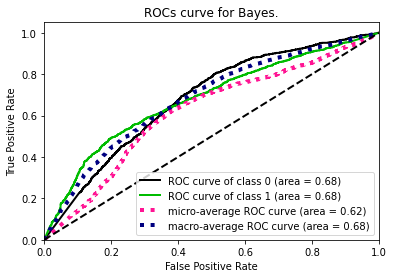

In [20]:
plt.figure(figsize = (12, 12))

roc(gnb, 'Bayes')

+ ### Some classification reports:

In [21]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.69      0.52      1210
           1       0.82      0.59      0.69      2855

    accuracy                           0.62      4065
   macro avg       0.62      0.64      0.60      4065
weighted avg       0.70      0.62      0.64      4065



+ ### Confusion Matrices:

We plotted both normalized and confusion matrices for this model, and we got that it classifies better 0-classes than 1-classes. 

It also shows that false positive rate is about 31%, a value that seems not to be as low as we would like, but it is acceptable for this model.

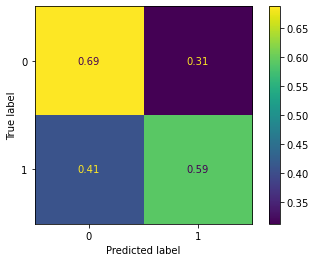

In [22]:
plot_confusion_matrix(gnb, xtest, y_true=ytest, normalize='true');

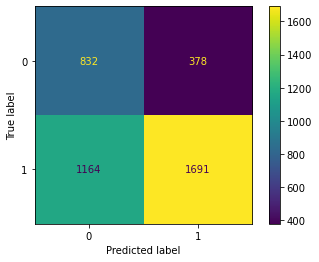

In [23]:
plot_confusion_matrix(gnb, X=xtest, y_true=ytest);

+ ### Cumulative Gain Curves:

This curves shows the percentage of sample we may study in order to get back as much information for predicted classes as posible. For our concerned cases this plot shows out that taking a sample of 40% of the data, we will be able to reproduce the 60% of class 0 responders. 

In the other hand, we need almost half of the data sample to predict a 60% of class-1 responders. 

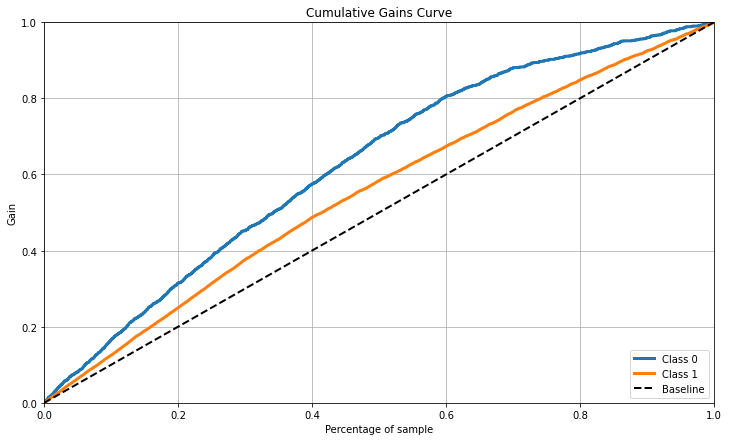

In [24]:
skplt.metrics.plot_cumulative_gain(ytest, y_prob, figsize=(12, 7));

+ ### ROC curve with optimal point:

If we plot out the ROC curve and explicitly highlight the best score for that ROC, we will be obtaining the metric that appears in the accuracy part.

In [27]:
probabilidad_po = y_prob[:, 1]

In [41]:
falsos_po, verdaderos_po, intervalos = roc_curve(ytest, 
                                                 probabilidad_po, 
                                                 pos_label=1)

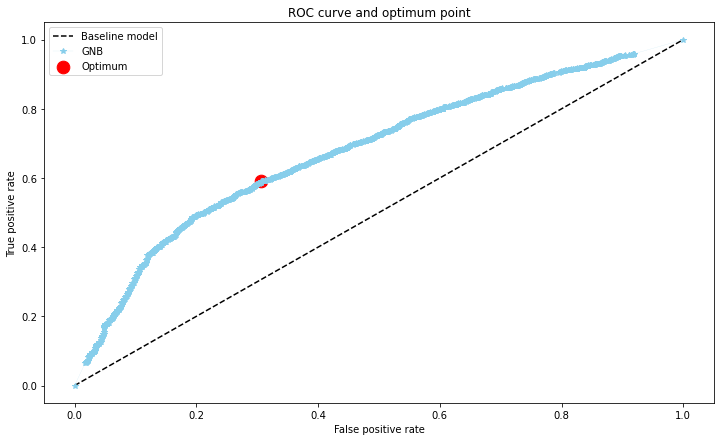

In [63]:
media = np.sqrt(verdaderos_po * (1-falsos_po))
maximo_g = np.argmax(media)

plt.figure(figsize=(12, 7))

# Hacemos los plots
plt.plot([0,1], [0,1], 
         linestyle='--', # linea punteada
         color='black',
         label='Baseline model') 

# Esto es la ROC.

plt.plot(falsos_po,
         verdaderos_po, 
         marker='*',
         linewidth=0.1,
         color='skyblue',
         label='GNB')


plt.scatter(falsos_po[maximo_g], 
            verdaderos_po[maximo_g], 
            s=160, 
            marker='o', 
            color='red', 
            label='Optimum')

plt.title('ROC curve and optimum point')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend();

## Logistic Regression comparision:

In order to get a comparision with other classification models, we will compare GNB with LR model to see how differently they behave.

In [53]:
logistic_model = Pipeline(steps=[
    
                                ('preprocesador', tratamiento),
    
                                ('clasificador', LogisticRegression(max_iter=1500, 
                                                                    random_state=1789))])

logistic_model.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=20,
                                                                              weights='distance')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Revenue Growth', 'Cost of Revenue', 'EPS', 'Dividend per Share',
       'Gross Margin', 'EBITDA Margin', 'Free Cash Flow margin', 'Receivables',
       'Inventories', 'Total assets', 'Total current liabi...
       'Net Income per Share', 'Net Debt to EBITDA', 'Current ratio', 'ROIC',
       'Enterprise Value over EBITDA', 'EBITDA Margin Company vs. Sector [%]',
       'FCF Margin Company vs. Sector [%]', 'EPS C

+ ### LR Scores:

Logistic regression classification is slightly worse than those obtained for Gaussian Naive-Bayes model:

In [54]:
logistic_model.score(xtrain, ytrain)

0.5799795464115984

In [55]:
logistic_model.score(xtest, ytest)

0.5958179581795818

+ ### LR Predictions and Probabilities:

In [56]:
y_pred = logistic_model.predict(xtest)

In [57]:
y_prob = logistic_model.predict_proba(xtest)

+ ### ROC GNB model:

In [58]:
def roc(model, title):
    
    skplt.metrics.plot_roc(ytest, y_prob) # un roc con todas las metricas
    plt.title(f"ROCs curve for {title}.");

We see that the ROCs curves for LR model are quite worse than those obtained for Naive Bayes model. 

The AUC we get back is almost 0.65. Logistic regression is the simpliest classification model we have studied, so despite its simplicity, the results it gives out are not so bad at all.

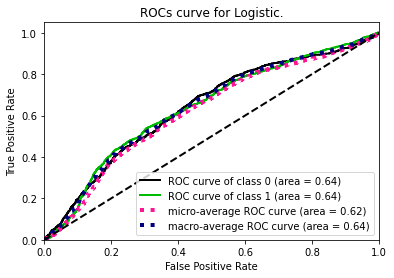

In [59]:
roc(logistic_model, 'Logistic')

+ ### Some classification reports:

Both f1-scores are worse than those obtained for NB model.

In [60]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.65      0.49      1210
           1       0.79      0.57      0.67      2855

    accuracy                           0.60      4065
   macro avg       0.59      0.61      0.58      4065
weighted avg       0.67      0.60      0.61      4065



+ ### Confusion Matrices:

We plotted both normalized and confusion matrices for this model, and we got that it classifies better 0-classes than 1-classes. 

It also shows that false positive rate is about 35%, a value that seems not to be as low as we would like, even higher than NB one, but it is acceptable for this model.

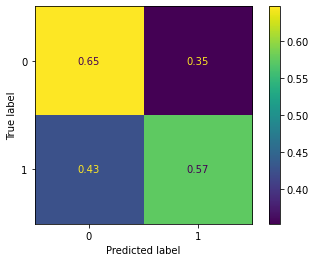

In [61]:
plot_confusion_matrix(logistic_model, xtest, y_true=ytest, normalize='true');

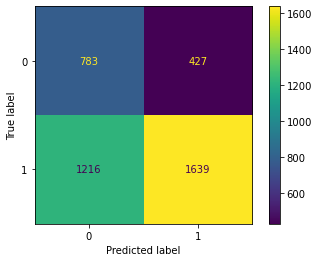

In [62]:
plot_confusion_matrix(logistic_model, X=xtest, y_true=ytest);

+ ### Cumulative Gain Curves:

This curves shows the percentage of sample we may study in order to get back as much information for predicted classes as posible. For our concerned cases this plot shows out that taking a sample of 40% of the data, we will be able to reproduce 55% of class-0 responders. 

In the other hand, class-1 responders are quite related to baseline predictions; it is necessary to study the 50% of the data to achieve a 60% class-1 responders.

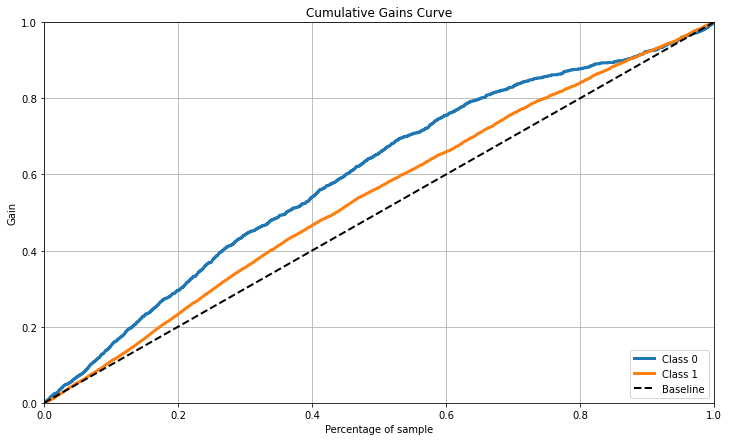

In [64]:
skplt.metrics.plot_cumulative_gain(ytest, y_prob, figsize=(12, 7));

+ ### ROC curve with optimal point:

If we plot out the ROC curve and explicitly highlight the best score for that ROC, we will be obtaining the metric that appears in the accuracy part.

In [65]:
probabilidad_po = y_prob[:, 1]

In [66]:
falsos_po, verdaderos_po, intervalos = roc_curve(ytest, 
                                                 probabilidad_po, 
                                                 pos_label=1)

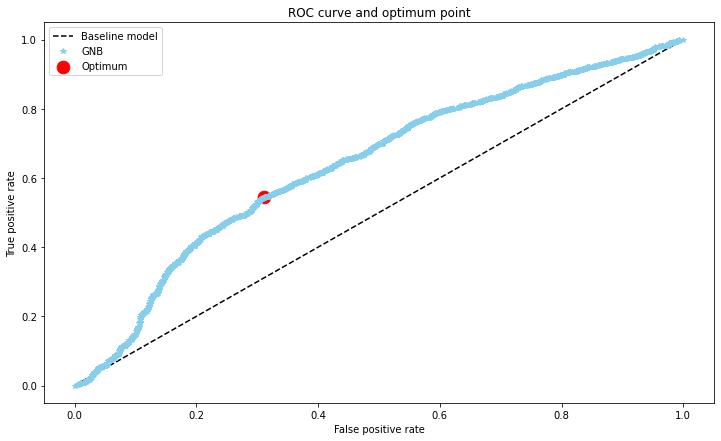

In [67]:
media = np.sqrt(verdaderos_po * (1-falsos_po))
maximo_g = np.argmax(media)

plt.figure(figsize=(12, 7))

# Hacemos los plots
plt.plot([0,1], [0,1], 
         linestyle='--', 
         color='black',
         label='Baseline model') 

# Plot de la roc
plt.plot(falsos_po,
         verdaderos_po, 
         marker='*',
         linewidth=0.1,
         color='skyblue',
         label='GNB')


plt.scatter(falsos_po[maximo_g], 
            verdaderos_po[maximo_g], 
            s=160, 
            marker='o', 
            color='red', 
            label='Optimum')

# Etiquetas 
plt.title('ROC curve and optimum point')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend();

## Bibliography:

+ https://towardsdatascience.com/evaluate-model-performance-with-cumulative-gains-and-lift-curves-1f3f8f79da01


+ https://nilimeshhalder.medium.com/multiclass-classification-using-naïve-bayes-classifiers-in-python-an-applied-machine-learning-afe38951daa4


+ https://towardsdatascience.com/tuning-parameters-heres-how-39a4d1956f79